In [0]:
!pip install tflearn
!pip uninstall tensorflow_estimator
!pip install tensorflow_estimator
!pip install tensorflow==1.13.2


     |████████████████████████████████| 102kB 2.4MB/s 
  Created wheel for tflearn: filename=tflearn-0.3.2-cp36-none-any.whl size=128208 sha256=97bf3d3149b4c1556a8b3c86005a847a1909a37d92be5db4517bb441ff9b6a32
  Stored in directory: /root/.cache/pip/wheels/d0/f6/69/0ef3ee395aac2e5d15d89efd29a9a216f3c27767b43b72c006
Successfully built tflearn
Uninstalling tensorflow-estimator-2.2.0:
  Would remove:
    /usr/local/lib/python3.6/dist-packages/tensorflow_estimator-2.2.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_estimator/*
Proceed (y/n)? y
  Successfully uninstalled tensorflow-estimator-2.2.0
     |████████████████████████████████| 460kB 2.8MB/s 
     |████████████████████████████████| 92.6MB 55kB/s 
     |████████████████████████████████| 3.2MB 42.4MB/s 
     |████████████████████████████████| 368kB 43.1MB/s 
  Found existing installation: tensorboard 2.2.1
    Uninstalling tensorboard-2.2.1:
      Successfully uninstalled tensorboard-2.2.1
  Found existing installa

In [0]:
!git clone https://shashikumarkm@bitbucket.org/shashikumarkm/dogsvscats.git

Cloning into 'dogsvscats'...
remote: Counting objects: 29255, done.
remote: Compressing objects: 100% (29253/29253), done.
remote: Total 29255 (delta 2), reused 29254 (delta 1)
Receiving objects: 100% (29255/29255), 633.91 MiB | 15.29 MiB/s, done.
Resolving deltas: 100% (2/2), done.
Checking out files: 100% (29276/29276), done.


In [0]:
import cv2                 # working with, mainly resizing, images
import numpy as np         # dealing with arrays
import os                  # dealing with directories
from random import shuffle # mixing up or currently ordered data that might lead our network astray in training.
from tqdm import tqdm      # a nice pretty percentage bar for tasks. 

TRAIN_DIR = 'dogsvscats/train'
TEST_DIR = 'dogsvscats/test'
IMG_SIZE = 50     #50 x 50 images.. perfect square images are easier to process
LR = 1e-3      #learning rate

MODEL_NAME = 'dogsvscats-{}-{}.model'.format(LR, '2conv-basic') 

In [0]:
#Helper function: Process the images and convert it into a 2D array, greyscale data
def label_img(img):
    word_label = img.split('.')[-3] #Example file name is dog.92.png then it considers only dog
    # conversion to one-hot array [cat,dog]
    if word_label == 'cat': return [1,0]    #[much cat, no dog]
    elif word_label == 'dog': return [0,1]      #[no cat, very dog]

In [0]:
#Helper function: which helps to create a list of the training data with the image and its respective label
def create_train_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE) #read the full path of the image
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE)) #resize just in case, some image isnt perfect 50x50
        training_data.append([np.array(img),np.array(label)]) #this creates a list with the image (its full path) and also the label - dog or cat
    shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [0]:
def process_test_data():
    testing_data = []
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [0]:
train_data = create_train_data()
# If you have already created the dataset:
#train_data = np.load('train_data.npy',allow_pickle=True)

100%|██████████| 25000/25000 [00:27<00:00, 894.75it/s]


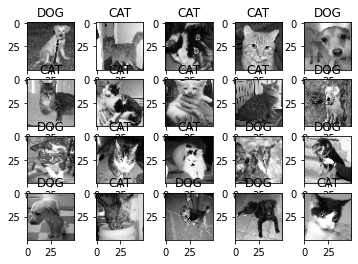

In [0]:
import matplotlib.pyplot as plt
from PIL import Image
for i in range(20):
  plt.subplot(4,5,i+1)
  if(train_data[i][1][0]==0):
    plt.title("DOG")
  else:
    plt.title("CAT")
  #plt.xlabel(train_data[i][1][0])
  plt.imshow(train_data[i][0], cmap=plt.get_cmap('gray'))
plt.show()

In [0]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input') #50x50 is the image size

convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 128, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 256, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)

convnet = conv_2d(convnet, 512, 3, activation='relu')
convnet = max_pool_2d(convnet, 3)


convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax') #2 examples - it is either a dog or a cat
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')


#model = tflearn.DNN(convnet, tensorboard_dir='log')
model = tflearn.DNN(convnet,checkpoint_path = '/tmp/tflearn_logs/',max_checkpoints=1, tensorboard_verbose=0)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
keep_dims is deprecated, use keepdims instead
Instructions for updating:
Use tf.cast instead.


In [0]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('model loaded!')

In [0]:
train = train_data[:-500] #Training data is all images, except the last 500 images - which we are going to use as validation set
test = train_data[-500:] #This is the validation / label data, to check accuracy

In [0]:
#This is what is getting fit in the model
X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1) #train contains image and label both
Y = [i[1] for i in train]

# this is for testing the accuracy of the model / the validation set
test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [0]:
history = model.fit({'input': X}, {'targets': Y}, n_epoch=10, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)


Training Step: 3829  | total loss: 0.13544 | time: 550.606s
| Adam | epoch: 010 | loss: 0.13544 - acc: 0.9436 -- iter: 24448/24500
Training Step: 3829  | total loss: 0.13544 | time: 550.606s
| Adam | epoch: 010 | loss: 0.13544 - acc: 0.9436 -- iter: 24448/24500
Training Step: 3830  | total loss: 0.12950 | time: 554.627s
| Adam | epoch: 010 | loss: 0.12950 - acc: 0.9477 | val_loss: 0.61226 - val_acc: 0.8160 -- iter: 24500/24500
--
Training Step: 3830  | total loss: 0.12950 | time: 554.627s
| Adam | epoch: 010 | loss: 0.12950 - acc: 0.9477 | val_loss: 0.61226 - val_acc: 0.8160 -- iter: 24500/24500
--


In [0]:
%load_ext tensorboard
%tensorboard --logdir /tmp/tflearn_logs

In [0]:
model.save(MODEL_NAME)

100%|██████████| 4276/4276 [00:04<00:00, 872.95it/s]


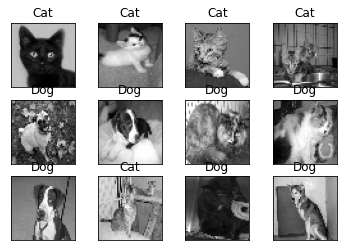

In [0]:
import matplotlib.pyplot as plt

# if you need to create the data:
test_data = process_test_data()
# if you already have some saved:
#test_data = np.load('test_data.npy')

fig=plt.figure()

for num,data in enumerate(test_data[0:12]): #Just plotted the first 12 data, to see if the model predicts the right labels
    # cat: [1,0]
    # dog: [0,1]
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1) #3x4 sub plot for the 12 images
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])[0] #prediction takes a list, so it only returns the 0th element
    
    if np.argmax(model_out) == 1: str_label='Dog' #printing labels below the images
    else: str_label='Cat'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label) 
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()



In [0]:
from tensorboard import notebook
notebook.list() # View open TensorBoard instances
notebook.display(port=6006, height=1000) 

No known TensorBoard instances running.
